In [1]:
# conversion rate A/B testing
# H0: new design has same conversion rate as old design
# Ha: new design has different conversion rate as old design
# here we are keeping our threshold value alpha = 0.05 and cofidence interval of 95%

Here we are keeping alpha as threshold because we want to convey that " If the probability of observing a result as extreme or more p-value is lower than alpha, then we reject the null hypothesis. since our alpha is 0.05 that means our confidence( 1 - alpha) is 95%

In [2]:
# in order to choose the correct sample size there is something known as power analysis. Which depends on few factors.
# 1) Power of the test (1- beta) - this means probability of finding statistical difference between groups in our test
# when a difference is actually present. 
# 2) Aplha value
# 3) Effect size - how big of the difference we expect there to be between the conversion rates

In [3]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from math import ceil

In [4]:
%matplotlib inline

In [5]:
effect_size = sms.proportion_effectsize(0.13,0.15)

required_n = ceil(sms.NormalIndPower().solve_power(effect_size,power=0.90,alpha=0.05,ratio=1))

print(required_n)

6319


we need sample size of 6319 observations for each group ( controlled group and treatment group)

In [6]:
data = pd.read_csv("ab_data.csv")

In [7]:
data

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
...,...,...,...,...,...
294473,751197,2017-01-03 22:28:38.630509,control,old_page,0
294474,945152,2017-01-12 00:51:57.078372,control,old_page,0
294475,734608,2017-01-22 11:45:03.439544,control,old_page,0
294476,697314,2017-01-15 01:20:28.957438,control,old_page,0


In [8]:
session_counts = data['user_id'].value_counts(ascending = False)
multi_users = session_counts[session_counts > 1].count()
print(f'there are {multi_users} users that appear multiple times in dataset')

there are 3894 users that appear multiple times in dataset


In [9]:
users_to_drop = session_counts[session_counts>1].index
data = data[~data['user_id'].isin(users_to_drop)]
print(f'the updated dataset now has {data.shape[0]} entries')

the updated dataset now has 286690 entries


In [10]:
control_sample = data[data['group']=='control'].sample(n=required_n,random_state=7)
treatment_sample = data[data['group']=='treatment'].sample(n=required_n,random_state=7)

ab_test = pd.concat([control_sample,treatment_sample],axis = 0)
ab_test.reset_index(drop=True, inplace=True)

ab_test

,user_id,timestamp,group,landing_page,converted
0,907002,2017-01-23 07:10:53.019304,control,old_page,0
1,688556,2017-01-11 01:40:35.354380,control,old_page,0
2,726787,2017-01-07 10:07:50.792649,control,old_page,0
3,799113,2017-01-09 05:22:59.117567,control,old_page,0
4,827699,2017-01-06 21:01:22.485309,control,old_page,0
...,...,...,...,...,...
12633,893037,2017-01-23 21:38:48.674260,treatment,new_page,1
12634,936911,2017-01-18 09:26:36.959314,treatment,new_page,0
12635,843262,2017-01-12 00:50:08.086284,treatment,new_page,0
12636,817871,2017-01-14 01:33:42.264216,treatment,new_page,0


In [11]:
ab_test['group'].value_counts()

control      6319
treatment    6319
Name: group, dtype: int64

In [12]:
conversion_rates = ab_test.groupby('group')['converted']

sdp = lambda x:np.std(x,ddof=0)
serror = lambda x:stats.sem(x,ddof=0)

conversion_rates = conversion_rates.agg([np.mean,sdp,serror])
conversion_rates.columns = ['conversion rate','standard deviation','standard error']
conversion_rates.style.format('{:.3f}')

,conversion rate,standard deviation,standard error
group,,,
control,0.127,0.333,0.004
treatment,0.122,0.327,0.004


Text(0, 0.5, 'Converted (proportion)')

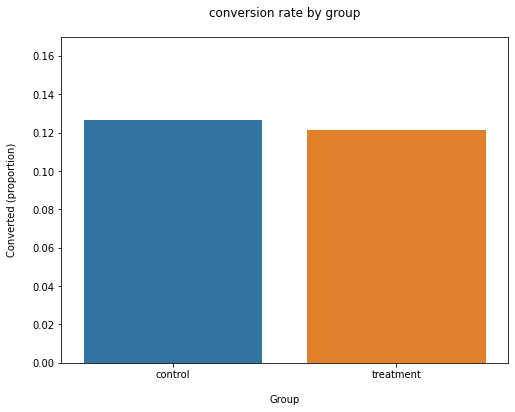

In [13]:
plt.figure(figsize=(8,6))
sns.barplot(x=ab_test['group'], y=ab_test['converted'],ci=False)

plt.ylim(0,0.17)
plt.title('conversion rate by group',pad=20)
plt.xlabel('Group',labelpad = 15)
plt.ylabel('Converted (proportion)',labelpad=15)

In [14]:
from statsmodels.stats.proportion import proportions_ztest,proportion_confint

control_results = ab_test[ab_test['group']=='control']['converted']
treatment_results = ab_test[ab_test['group']=='treatment']['converted']

n_control = control_results.count()
n_treatment = treatment_results.count()
successes = [control_results.sum(),treatment_results.sum()]
n_observation = [n_control,n_treatment]

z_stat, pval = proportions_ztest(successes, nobs=n_observation)
(lower_con,lower_treat),(upper_con,upper_treat) = proportion_confint(successes,nobs=n_observation,alpha=0.05)

print(f'z stats: {z_stat:.2f}')
print(f'p value : {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z stats: 0.86
p value : 0.388
ci 95% for control group: [0.118, 0.135]
ci 95% for treatment group: [0.113, 0.130]
